# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from WMEM_PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [ ]:
plt.rcParams.update({'font.size':22})

# train and eval script

In [3]:
seed = 1
tr.manual_seed(seed)
np.random.seed(seed)

In [4]:
## task
nback = 1
num_pmtrials = 5
og_signal_dim = 8
pm_signal_dim = 8
og_noise_dim = 0
pm_noise_dim = 0
ntokens_og = 3 

## network
indim = og_signal_dim+og_noise_dim
stsize = 30 #
batch=1
outdim=3
EM=0

trseqlen=20
pm_weight=1

# model and task
net = PMNet(indim,stsize,outdim,EM)
task = NBackPMTask(nback,num_pmtrials,og_signal_dim,pm_signal_dim,og_noise_dim,pm_noise_dim,ntokens_og,seed)
net

PMNet(
  (ff_in): Linear(in_features=8, out_features=30, bias=True)
  (relu_in): ReLU()
  (cell): LSTMCell(30, 30)
  (ff_out1): Linear(in_features=30, out_features=30, bias=True)
  (relu_out): ReLU()
  (ff_out2): Linear(in_features=30, out_features=3, bias=True)
  (rgate): Linear(in_features=30, out_features=30, bias=True)
  (sigm): Tanh()
)

### train

In [5]:
def train(net,task,nepochs=1000,thresh=.9,pm_weight=1):
  weight=tr.FloatTensor([1,1,pm_weight])
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.0005)
  acc,nembeds = 0,0
  for ep in range(nepochs):
    if ep%(nepochs/5)==0:
      print(ep/nepochs,nembeds)
    # randomize emat
    if acc>thresh:
      task.sample_emat()
      nembeds+=1
    # generate data
    x_seq,y_seq = task.gen_seq(trseqlen)
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    # collect loss through time
    loss,acc = 0,0
    for tstep,(yh,yt) in enumerate(zip(yhat,ytarget)):
      loss += weight[yt]*lossop(yh,yt)
      acc += yt==tr.argmax(tr.softmax(yh,1))
    acc = acc.numpy()/len(yhat)
    # bp and update
    optiop.zero_grad()
    loss.backward()
    optiop.step()
    epoch_loss = loss.item()
  return net

def eval_(net,task,neps=1500,teseqlen=15,verb=False):
  score = -np.ones([neps,teseqlen])
  rgate = -np.ones([neps,teseqlen,net.stsize])
  for ep in range(neps):
    # embedding matrix
    task.sample_emat()
    # generate data
    x_seq,y_seq = task.gen_seq(teseqlen,pm_trial_position=[5,9])
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    if verb:
      print(net.sim)
      print(net.sim[(6,11),:])
      print(net.sim[(1,2,3,4),:])
      print(net.rgate_act.shape)
    ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
    score[ep] = ep_score 
    rgate[ep] = net.rgate_act.detach().numpy()
  return score,rgate


In [6]:
net = train(net,task,nepochs=40000,pm_weight=pm_weight)

0.0 0
0.2 166
0.4 638
0.6 1839
0.8 3451


In [7]:
score,rgate = eval_(net,task,neps=500)

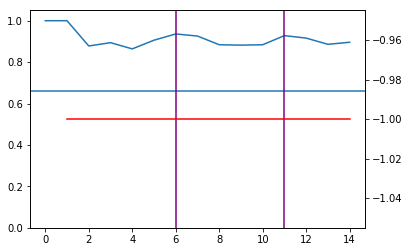

In [8]:
ax = plt.gca()

ax.set_ylim(0,1.05)
ax.plot(score.mean(0))
ax.axhline(.66)
ax2 = plt.twinx()
ax2.plot(np.arange(1,15),rgate[:,1:].mean((0,2)),c='r')

for t in [6,11]:
  ax.axvline(t,c='purple')
